###  Feature Pyramid Network

**Reference:**
Kirillov, Alexander, et al. "Panoptic feature pyramid networks." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019. [(link)](https://arxiv.org/pdf/1901.02446.pdf)

**Description:** FPN takes a standard CNN backbone with features at multiple spatial resolutions, and adds a light top-down pathway with lateral connections. The top-down pathway progressively upsamples the deepest feature map from the backbone while adding in transformed versions of higher-resolution features from the bottom-up pathway. Multiple segmentation heads merge the information from all levels of the FPN pyramid into a single output.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

The *datasets* folder contains some helper functions to generate toy datasets.

In [2]:
from datasets.utils import generate_train_and_test_data
from datasets.segmentation.circle_segmentation import circle_segmentation_sample

Generate some synthetic training data, using the helper functions in the *dataset* module:

In [3]:
(X_train, Y_train), (X_test, Y_test) = \
    generate_train_and_test_data(circle_segmentation_sample,
                                 n_samples_train=10000, n_samples_test=1000,
                                 width=32, height=32)

The dataset consists of 32x32 images displaying a circle of a random color and size over a bunch of geometric shapes. The goal is to segment the circle:

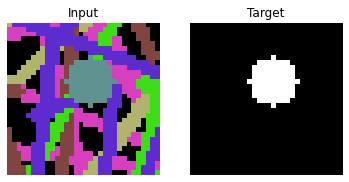

In [4]:
import matplotlib.pyplot as plt

idx = np.random.randint(X_test.shape[0])

ax = plt.subplot(121)
ax.imshow(X_test[idx,:,:])
ax.set_title("Input")
ax.axis("off")
ax = plt.subplot(122)
ax.imshow(Y_test[idx,:,:,0], cmap="gray")
ax.set_title("Target")
ax.axis("off")
plt.show()

Scale pixel values to the [0, 1] range:

In [5]:
X_train = X_train / 255
X_test = X_test / 255

We use a very simplified architecture which still illustrates the main features of the FPN achitecture. For full details about the original architecture, check the refecenes. Note that the main differences with respect to the simpler Unet architecture are:

- Latelar connections transform the feature maps via a 1x1 Convolution
- Lateral connections are merged via addition, not concatenation
- Upsampling is used to scale feature maps up, rather than using transposed convolutions
- Multiple segmentation heads applied at different levels of the fature pyramid

REF: http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf

REF: Kirillov, Alexander, et al. "Panoptic feature pyramid networks." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.


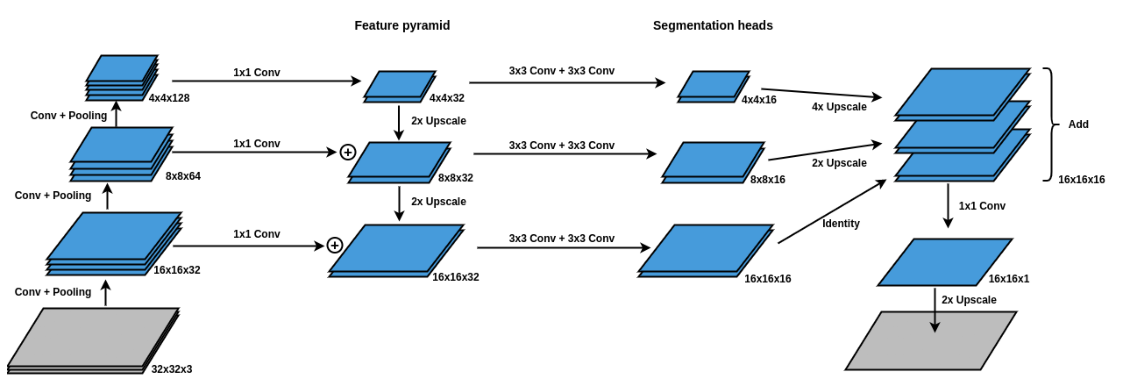

In [6]:
def FPNBlock(filters):
    """ Modular operation which upscales an input tensor and merges it with a lateral connection"""
    def wrapper(input_tensor, skip):
        if input_tensor is None:
            return keras.layers.Conv2D(filters=filters, kernel_size=1)(skip)
        else:
            skip = keras.layers.Conv2D(filters=filters, kernel_size=1)(skip)
            x = keras.layers.UpSampling2D(2)(input_tensor)
            x = keras.layers.Add()([x, skip])
            return x
    return wrapper

def SegmentationHead(filters, upsampling=1):
    """ Segmentation head which transforms a feature map by applying two convolution layers and upsampling"""
    def wrapper(input_tensor):
        x = keras.layers.Conv2D(filters, kernel_size=3, activation="relu", padding="same")(input_tensor)
        x = keras.layers.Conv2D(filters, kernel_size=3, activation="relu", padding="same")(x)
        x = keras.layers.UpSampling2D(upsampling)(x)
        return x
    return wrapper

In [8]:
feature_pyramind_filters = 32
segmentation_heads_filters = 16

input_tensor = keras.layers.Input((32,32,3))

# Bottom-up pathway
conv1 = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_tensor) 
maxp1 = keras.layers.MaxPool2D((2,2))(conv1)                                    
conv2 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(maxp1) 
maxp2 = keras.layers.MaxPool2D((2,2))(conv2)                                     
conv3 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(maxp2)
maxp3 = keras.layers.MaxPool2D((2,2))(conv3)      
conv4 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(maxp3)
maxp4 = keras.layers.MaxPool2D((2,2))(conv4)     

# Top-down pathway (feature pyramid)
fp3 = FPNBlock(filters=feature_pyramind_filters)(None, conv4)
fp2 = FPNBlock(filters=feature_pyramind_filters)(fp3, conv3)
fp1 = FPNBlock(filters=feature_pyramind_filters)(fp2, conv2)

# Segmentation heads
s3 = SegmentationHead(filters=segmentation_heads_filters, upsampling=4)(fp3)
s2 = SegmentationHead(filters=segmentation_heads_filters, upsampling=2)(fp2)
s1 = SegmentationHead(filters=segmentation_heads_filters)(fp1)

# Merge segmentation heads to produce the final prediction
s_add = keras.layers.Add()([s1, s2, s3])
final_conv = keras.layers.Conv2D(1, kernel_size=1, padding="same")(s_add)
final_conv_upsampled = keras.layers.UpSampling2D(2)(final_conv)
segmentation_output = keras.layers.Activation("sigmoid")(final_conv_upsampled)

model = keras.models.Model(input_tensor, segmentation_output)

With the model defined, we proceed to train it. This should take only a few moments even on the CPU.

In [9]:
model.compile("adam", "binary_crossentropy")

In [10]:
model.fit(X_train, Y_train, epochs=20, batch_size=64)

Epoch 1/20
157/157 [==============================] - 1s 7ms/step - loss: 0.2187
Epoch 2/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0944
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0627
Epoch 4/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0489
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0440
Epoch 6/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0411
Epoch 7/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0391
Epoch 8/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0376
Epoch 9/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0367
Epoch 10/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0354
Epoch 11/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0346
Epoch 12/20
157/157 [==============================] - 1s 6ms/step - loss: 0.0339
Epoch 13/20
157/157 [====

After training, the model should be able to segment the circles in test images:

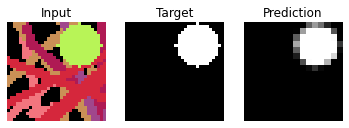

In [12]:
idx = np.random.randint(X_test.shape[0])

ax = plt.subplot(131)
ax.imshow(X_test[idx,:,:])
ax.set_title("Input")
ax.axis("off")
ax = plt.subplot(132)
ax.imshow(Y_test[idx,:,:,0], cmap="gray")
ax.set_title("Target")
ax.axis("off")
ax = plt.subplot(133)
ax.imshow(model.predict(X_test[idx:idx+1])[0,:,:,0], cmap="gray")
ax.set_title("Prediction")
ax.axis("off")
plt.show()